In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import h5py

import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score,f1_score # pour voir l'efficacité globale du modèle
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


2024-01-18 16:44:39.364984: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 16:44:39.402846: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 16:44:39.402878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 16:44:39.403901: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 16:44:39.409431: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 16:44:39.409793: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Chemin vers vos fichiers HDF5
train_filepath = '/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/spectrogrammes/spectrogrammes_train.h5'
test_filepath = '/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/spectrogrammes/spectrogrammes_test.h5'
val_filepath = '/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/spectrogrammes/spectrogrammes_val.h5'

In [3]:
#Charger les mean et std pour les données de validation

with h5py.File(val_filepath, 'r') as file:
    mean_val = file['spectrogramme'][:].mean()
    std_val = file['spectrogramme'][:].std()

# Créez une fonction qui génère des lots de données à partir des fichiers HDF5 car on ne peut pas les charger entier + Standardisation au passage selon les données de validation
def data_generator(filepath, batch_size,mean,std):
    while True:
        with h5py.File(filepath, 'r') as file:
            num_samples = file['spectrogramme'].shape[0] #nb de spectrogramme
            num_batches = num_samples // batch_size 

            # Créez un tableau d'indices aléatoires pour un nb d'echantillons ceci à chaque epoch 
            random_indices = np.random.permutation(num_samples)

            for i in range(num_batches):
                start = i * batch_size
                end = (i + 1) * batch_size

                # Sélectionnez les indices aléatoires pour ce lot
                batch_indices = random_indices[start:end]

                X_batch = (file['spectrogramme'][np.sort(batch_indices)]-mean)/std# Chargez les spectrogrammes
                y_batch = file['post_label'][np.sort(batch_indices)] # Chargez les étiquettes 
                
                yield X_batch, y_batch

## Modèle de réseaux de neurones à convolution 2

In [15]:
with h5py.File(train_filepath, 'r') as train_file:
    input_shape = train_file['spectrogramme'][0].shape #nb de spectrogramme
    
# Modèle CNN
model1 = Sequential()

# Couche de convolution 1
model1.add(Conv2D(16, kernel_size=(9, 9), activation='relu', input_shape=input_shape))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

# Aplatir les sorties pour les couches denses
model1.add(Flatten())

# Couches entièrement connectées
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.25))
model1.add(Dense(1, activation='sigmoid'))  # Sortie binaire

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 929, 93, 16)       1312      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 464, 46, 16)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 464, 46, 16)       0         
                                                                 
 flatten_2 (Flatten)         (None, 341504)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               87425280  
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                      

In [18]:
epochs = 10
lr = 0.0001
batch_size = 50

adam_optimizer = Adam(learning_rate=lr)

# Compiler le modèle
model1.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Créez des générateurs de données pour l'entraînement, la validation et les tests
train_generator = data_generator(train_filepath, batch_size,mean_val,std_val)
test_generator = data_generator(test_filepath, batch_size,mean_val,std_val)

with h5py.File(train_filepath, 'r') as train_file, h5py.File(test_filepath,'r') as test_file:
            num_train_samples = train_file['spectrogramme'].shape[0] #nb de spectrogramme
            num_test_samples = test_file['spectrogramme'].shape[0] #nb de spectrogramme


history1_1 = model1.fit(
    train_generator, # Utilisez le générateur de données d'entraînement
    steps_per_epoch=num_train_samples // batch_size, #nb d'étape par epoch
    epochs=epochs,
    validation_data=test_generator,  # Utilisez le générateur de données de test pour la validation
    validation_steps=num_test_samples // batch_size  # Définissez le nombre d'étapes de validation
)


# Sauvegardez le modèle dans un fichier
with open('/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/neuro_conv2.pkl', 'wb') as fichier:
    pickle.dump(model1, fichier)



Epoch 1/10
324/324 [==============================] - 1232s 4s/step - loss: 0.7175 - accuracy: 0.8156 - val_loss: 0.2362 - val_accuracy: 0.9188
Epoch 2/10
324/324 [==============================] - 1270s 4s/step - loss: 0.2103 - accuracy: 0.9244 - val_loss: 0.1709 - val_accuracy: 0.9376
Epoch 3/10
324/324 [==============================] - 1163s 4s/step - loss: 0.1541 - accuracy: 0.9492 - val_loss: 0.1987 - val_accuracy: 0.9178
Epoch 4/10
324/324 [==============================] - 1157s 4s/step - loss: 0.1241 - accuracy: 0.9579 - val_loss: 0.1476 - val_accuracy: 0.9453
Epoch 5/10
324/324 [==============================] - 1153s 4s/step - loss: 0.0948 - accuracy: 0.9683 - val_loss: 0.1936 - val_accuracy: 0.9245
Epoch 6/10
324/324 [==============================] - 1155s 4s/step - loss: 0.0674 - accuracy: 0.9799 - val_loss: 0.1386 - val_accuracy: 0.9479
Epoch 7/10
324/324 [==============================] - 1232s 4s/step - loss: 0.0509 - accuracy: 0.9849 - val_loss: 0.1455 - val_accuracy:

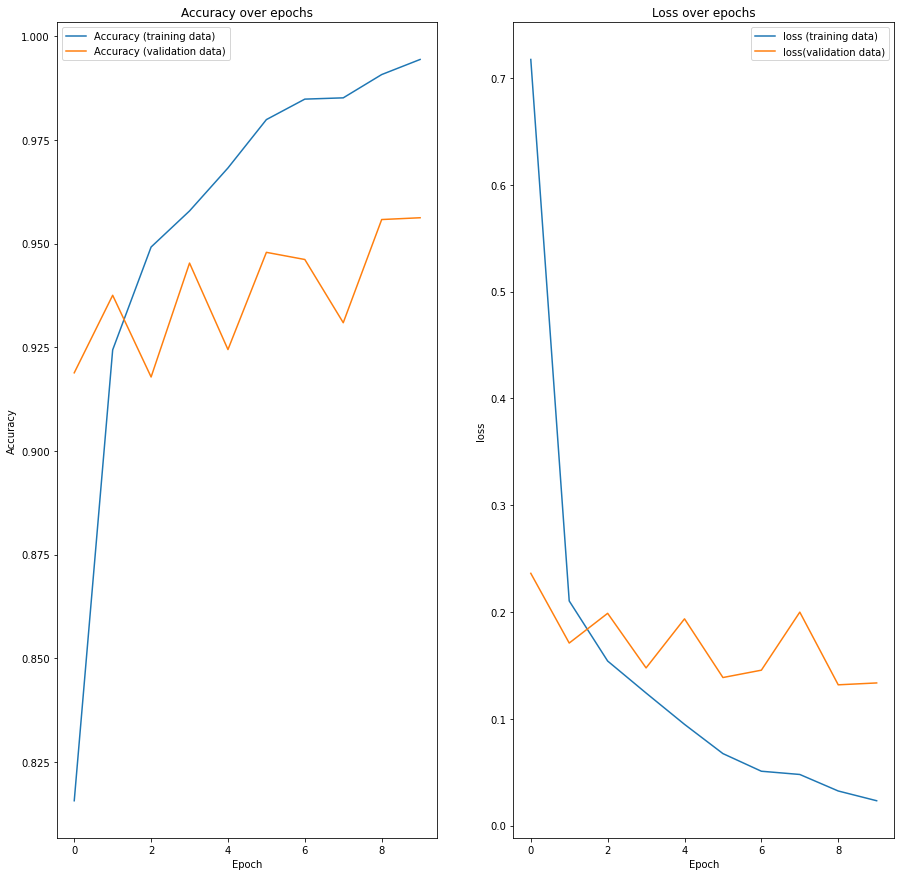

In [19]:
##Historique de l'apprentissage Modèle 1

#Score
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.plot(history1_1.history['accuracy'], label='Accuracy (training data)')
plt.plot(history1_1.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#Loss
plt.subplot(1,2,2)
plt.plot(history1_1.history['loss'], label='loss (training data)')
plt.plot(history1_1.history['val_loss'], label='loss(validation data)')
plt.title('Loss over epochs')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Évaluation du modèle 2

In [3]:
#Charger les mean et std pour les données de validation

with h5py.File(val_filepath, 'r') as file:
    mean_val = file['spectrogramme'][:].mean()
    std_val = file['spectrogramme'][:].std()

In [4]:
# Chargez le modèle à partir du fichier
with open('/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/neuro_conv2.pkl', 'rb') as fichier:
    model1 = pickle.load(fichier)

In [5]:

#Charger les données test
with h5py.File(test_filepath, 'r') as file:
    spectres_test = (file['spectrogramme'][:] - mean_val)/std_val
    post_label = file['post_label'][:]
    ech_test = [stri.decode('utf-8') for stri in file['ech'][:]] 

In [7]:
#Charger les données val
with h5py.File(val_filepath, 'r') as file:
    spectres_val = (file['spectrogramme'][:] - mean_val)/std_val
    ech_val = [stri.decode('utf-8') for stri in file['ech'][:]]

2023-12-30 20:02:29.681812: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2631287148 exceeds 10% of free system memory.


218/218 [==============================] - 77s 354ms/step
voici le seuil médian 0.52476305
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96      4140
         1.0       0.95      0.94      0.95      2811

    accuracy                           0.96      6951
   macro avg       0.96      0.95      0.95      6951
weighted avg       0.96      0.96      0.96      6951



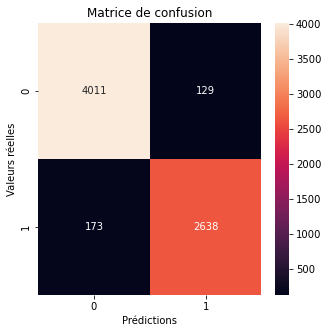

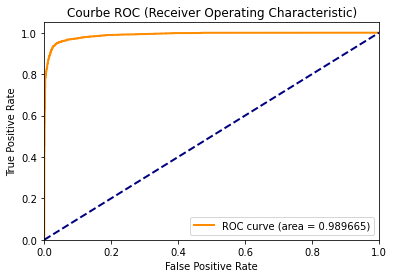

In [6]:
# Prédire les probabilités pour la classe positive
y_proba_pred_test = model1.predict(spectres_test)

# Calculer les scores TPR (True Positive Rate) et FPR (False Positive Rate)
fpr, tpr, thresholds = roc_curve(post_label, y_proba_pred_test)

#Trouver le bon indice pour le seuil de décision, au milieu de la courbe Roc
indice = int(np.floor(len(thresholds)/2))
print( "voici le seuil médian" ,thresholds[indice-1])

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

#Prédiction sur le seuil précédent
Y_pred = y_proba_pred_test > thresholds[indice-1]

#Rapport de classification  
matrix_conf = confusion_matrix(post_label,Y_pred)
print(classification_report(post_label,Y_pred))

##Matrice de confusion 
plt.figure(figsize=(5,5))
sns.heatmap(matrix_conf,annot=True,fmt='g')
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()


# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.6f})') # aire sous la courbe
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.show()

30/30 [==============================] - 9s 316ms/step


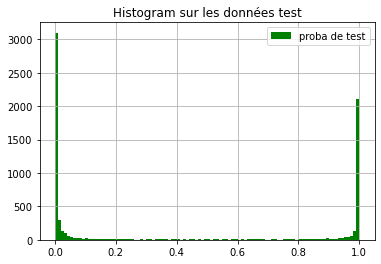

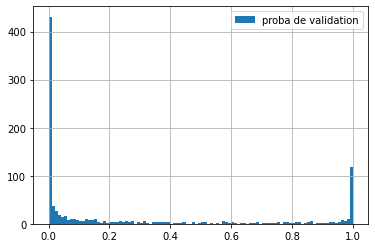

In [8]:
# Prédire les probabilités pour la classe positive
y_proba_pred_val = model1.predict(spectres_val)

plt.hist(y_proba_pred_test,100,color='g',density=False,label='proba de test')
plt.grid()
plt.legend()
plt.title("Histogram sur les données test")
plt.show()


plt.hist(y_proba_pred_val,100,density=False,label='proba de validation')
plt.grid()
plt.legend()
plt.show()

In [9]:

df_soumission10= pd.DataFrame(ech_val)
df_soumission10['pos_label'] = y_proba_pred_val
df_soumission10.index = df_soumission10[0]
df_soumission10.index.name = "id"
df_soumission10.drop(columns=0,axis=1,inplace=True)
df_soumission10.to_csv("/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/soumission10.csv")

In [12]:
df_soumission10.head(5)

,pos_label
id,
23331-TEST.wav,0.037719
24024-TEST.wav,0.000026
23561-TEST.wav,0.977139
24116-TEST.wav,0.999941
24001-TEST.wav,0.605839


## Modèle convolutionnel 3

In [3]:
with h5py.File(train_filepath, 'r') as train_file:
    input_shape = train_file['spectrogramme'][0].shape #nb de spectrogramme

model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 935, 99, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 467, 49, 32)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 467, 49, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 465, 47, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 232, 23, 64)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 232, 23, 64)       0

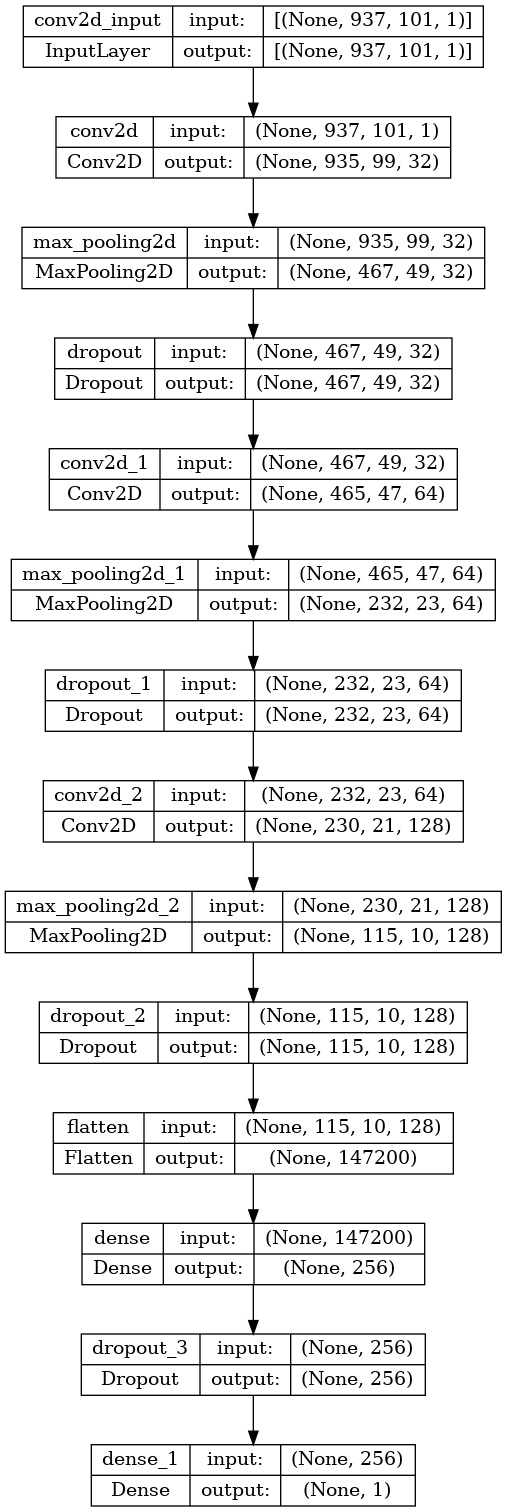

In [4]:
# Plotting the model
tf.keras.utils.plot_model(
    model2,
    to_file='model2.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96
)

In [10]:
#Charger les mean et std pour les données de validation

with h5py.File(test_filepath, 'r') as file:
    mean_train = file['spectrogramme'][:].mean()
    std_train = file['spectrogramme'][:].std()

epochs = 7
lr = 0.0001
batch_size = 60

adam_optimizer = Adam(learning_rate=lr)

# Compiler le modèle
model2.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Créez des générateurs de données pour l'entraînement, la validation et les tests
train_generator = data_generator(train_filepath, batch_size,mean_train,std_train)
test_generator = data_generator(test_filepath, batch_size,mean_train,std_train)

with h5py.File(train_filepath, 'r') as train_file, h5py.File(test_filepath,'r') as test_file:
            num_train_samples = train_file['spectrogramme'].shape[0] #nb de spectrogramme
            num_test_samples = test_file['spectrogramme'].shape[0] #nb de spectrogramme


history2_1 = model2.fit(
    train_generator, # Utilisez le générateur de données d'entraînement
    steps_per_epoch=num_train_samples // batch_size, #nb d'étape par epoch
    epochs=epochs,
    validation_data=test_generator,  # Utilisez le générateur de données de test pour la validation
    validation_steps=num_test_samples // batch_size  # Définissez le nombre d'étapes de validation
)

# Sauvegardez le modèle dans un fichier
with open('/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/neuro_conv3_3.pkl', 'wb') as fichier:
    pickle.dump(model2, fichier)

Epoch 1/7
270/270 [==============================] - 1656s 6s/step - loss: 0.4971 - accuracy: 0.7996 - val_loss: 0.4201 - val_accuracy: 0.8204
Epoch 2/7
270/270 [==============================] - 1640s 6s/step - loss: 0.2838 - accuracy: 0.8917 - val_loss: 0.3703 - val_accuracy: 0.8432
Epoch 3/7
270/270 [==============================] - 1646s 6s/step - loss: 0.2461 - accuracy: 0.9092 - val_loss: 0.2915 - val_accuracy: 0.8932
Epoch 4/7
270/270 [==============================] - 1665s 6s/step - loss: 0.2237 - accuracy: 0.9180 - val_loss: 0.2775 - val_accuracy: 0.8983
Epoch 5/7
270/270 [==============================] - 1670s 6s/step - loss: 0.1975 - accuracy: 0.9293 - val_loss: 0.2379 - val_accuracy: 0.9212
Epoch 6/7
270/270 [==============================] - 1675s 6s/step - loss: 0.1838 - accuracy: 0.9352 - val_loss: 0.2792 - val_accuracy: 0.8864
Epoch 7/7
270/270 [==============================] - 1662s 6s/step - loss: 0.1667 - accuracy: 0.9404 - val_loss: 0.2148 - val_accuracy: 0.9174

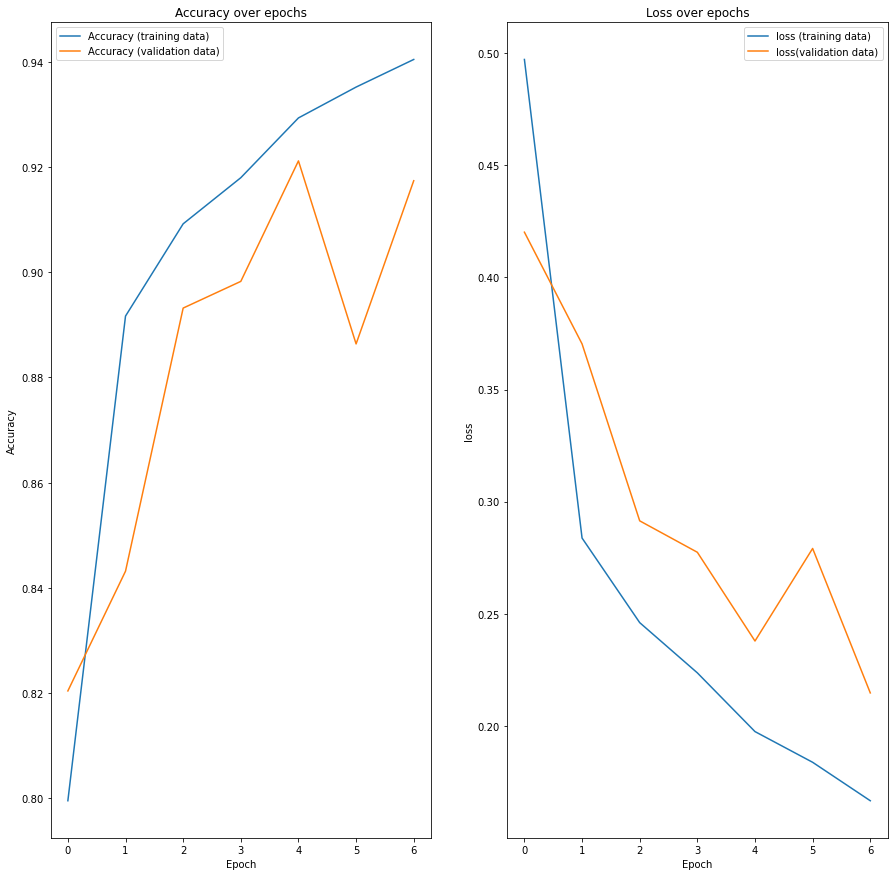

In [11]:
##Historique de l'apprentissage Modèle 1

#Score
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.plot(history2_1.history['accuracy'], label='Accuracy (training data)')
plt.plot(history2_1.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#Loss
plt.subplot(1,2,2)
plt.plot(history2_1.history['loss'], label='loss (training data)')
plt.plot(history2_1.history['val_loss'], label='loss(validation data)')
plt.title('Loss over epochs')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Évaluation du modèle 3

In [3]:
# Chargez le modèle à partir du fichier
with open('/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/neuro_conv3.pkl', 'rb') as fichier:
    model2 = pickle.load(fichier)

In [4]:
with h5py.File(val_filepath, 'r') as file:
    mean_val = file['spectrogramme'][:].mean()
    std_val = file['spectrogramme'][:].std()


with h5py.File(test_filepath, 'r') as file:
    mean_train = file['spectrogramme'][:].mean()
    std_train = file['spectrogramme'][:].std()

#Charger les données test
with h5py.File(test_filepath, 'r') as file:
    spectres_test = (file['spectrogramme'][:] - mean_train)/std_train
    post_label = file['post_label'][:]
    ech_test = [stri.decode('utf-8') for stri in file['ech'][:]] 

#Charger les données val
with h5py.File(val_filepath, 'r') as file:
    spectres_val = (file['spectrogramme'][:] - mean_val)/std_val
    ech_val = [stri.decode('utf-8') for stri in file['ech'][:]]

2023-12-31 17:23:34.184415: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2631287148 exceeds 10% of free system memory.


218/218 [==============================] - 165s 759ms/step
voici le seuil médian 0.40867308
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93      4140
         1.0       0.87      0.94      0.90      2811

    accuracy                           0.92      6951
   macro avg       0.91      0.92      0.92      6951
weighted avg       0.92      0.92      0.92      6951



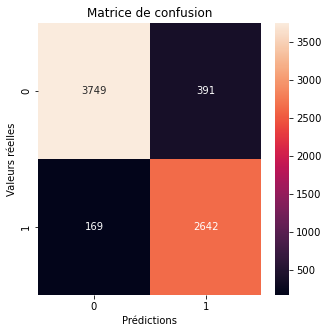

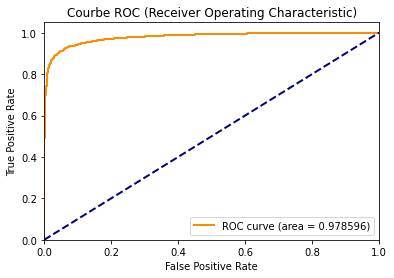

In [5]:
# Prédire les probabilités pour la classe positive
y_proba_pred_test = model2.predict(spectres_test)

# Calculer les scores TPR (True Positive Rate) et FPR (False Positive Rate)
fpr, tpr, thresholds = roc_curve(post_label, y_proba_pred_test)

#Trouver le bon indice pour le seuil de décision, au milieu de la courbe Roc
indice = int(np.floor(len(thresholds)/2))
print( "voici le seuil médian" ,thresholds[indice-1])

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

#Prédiction sur le seuil précédent
Y_pred = y_proba_pred_test > thresholds[indice-1]

#Rapport de classification  
matrix_conf = confusion_matrix(post_label,Y_pred)
print(classification_report(post_label,Y_pred))

##Matrice de confusion 
plt.figure(figsize=(5,5))
sns.heatmap(matrix_conf,annot=True,fmt='g')
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()


# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.6f})') # aire sous la courbe
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.show()

30/30 [==============================] - 22s 731ms/step


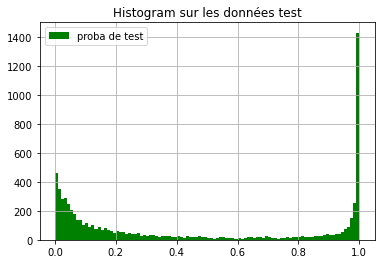

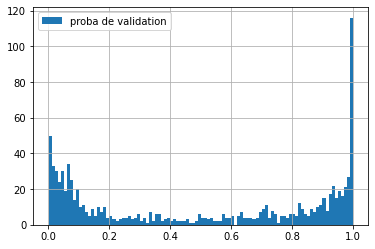

In [6]:
# Prédire les probabilités pour la classe positive
y_proba_pred_val = model2.predict(spectres_val)

plt.hist(y_proba_pred_test,100,color='g',density=False,label='proba de test')
plt.grid()
plt.legend()
plt.title("Histogram sur les données test")
plt.show()


plt.hist(y_proba_pred_val,100,density=False,label='proba de validation')
plt.grid()
plt.legend()
plt.show()

df_soumission11= pd.DataFrame(ech_val)
df_soumission11['pos_label'] = y_proba_pred_val
df_soumission11.index = df_soumission11[0]
df_soumission11.index.name = "id"
df_soumission11.drop(columns=0,axis=1,inplace=True)
df_soumission11.to_csv("/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/soumission11.csv")

## Modèle convolutionnel 4

In [4]:
with h5py.File(train_filepath, 'r') as train_file:
    input_shape = train_file['spectrogramme'][0].shape #nb de spectrogramme

model3 = Sequential([
    Conv2D(32, (9, 9), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 929, 93, 32)       2624      
                                                                 
 max_pooling2d (MaxPooling2  (None, 464, 46, 32)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 464, 46, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 460, 42, 64)       51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 230, 21, 64)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 230, 21, 64)       0

In [5]:
#Charger les mean et std pour les données de validation

with h5py.File(test_filepath, 'r') as file:
    mean_train = file['spectrogramme'][:].mean()
    std_train = file['spectrogramme'][:].std()

epochs = 7
lr = 0.0001
batch_size = 50

adam_optimizer = Adam(learning_rate=lr)

# Compiler le modèle
model3.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Créez des générateurs de données pour l'entraînement, la validation et les tests
train_generator = data_generator(train_filepath, batch_size,mean_train,std_train)
test_generator = data_generator(test_filepath, batch_size,mean_train,std_train)

with h5py.File(train_filepath, 'r') as train_file, h5py.File(test_filepath,'r') as test_file:
            num_train_samples = train_file['spectrogramme'].shape[0] #nb de spectrogramme
            num_test_samples = test_file['spectrogramme'].shape[0] #nb de spectrogramme


history3_1 = model3.fit(
    train_generator, # Utilisez le générateur de données d'entraînement
    steps_per_epoch=num_train_samples // batch_size, #nb d'étape par epoch
    epochs=epochs,
    validation_data=test_generator,  # Utilisez le générateur de données de test pour la validation
    validation_steps=num_test_samples // batch_size  # Définissez le nombre d'étapes de validation
)

# Sauvegardez le modèle dans un fichier
with open('/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/neuro_conv4.pkl', 'wb') as fichier:
    pickle.dump(model3, fichier)

Epoch 1/7
324/324 [==============================] - 2790s 9s/step - loss: 0.4105 - accuracy: 0.8257 - val_loss: 0.2984 - val_accuracy: 0.8938
Epoch 2/7
324/324 [==============================] - 2714s 8s/step - loss: 0.2493 - accuracy: 0.9078 - val_loss: 0.2994 - val_accuracy: 0.8824
Epoch 3/7
324/324 [==============================] - 2764s 9s/step - loss: 0.2104 - accuracy: 0.9263 - val_loss: 0.2218 - val_accuracy: 0.9223
Epoch 4/7
324/324 [==============================] - 2719s 8s/step - loss: 0.1763 - accuracy: 0.9377 - val_loss: 0.1587 - val_accuracy: 0.9453
Epoch 5/7
324/324 [==============================] - 2740s 8s/step - loss: 0.1434 - accuracy: 0.9499 - val_loss: 0.1495 - val_accuracy: 0.9466
Epoch 6/7
324/324 [==============================] - 2686s 8s/step - loss: 0.1204 - accuracy: 0.9582 - val_loss: 0.1229 - val_accuracy: 0.9591
Epoch 7/7
324/324 [==============================] - 2689s 8s/step - loss: 0.1013 - accuracy: 0.9646 - val_loss: 0.1117 - val_accuracy: 0.9624

NameError: name 'model2' is not defined

In [6]:
# Sauvegardez le modèle dans un fichier
with open('/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/neuro_conv4.pkl', 'wb') as fichier:
    pickle.dump(model3, fichier)

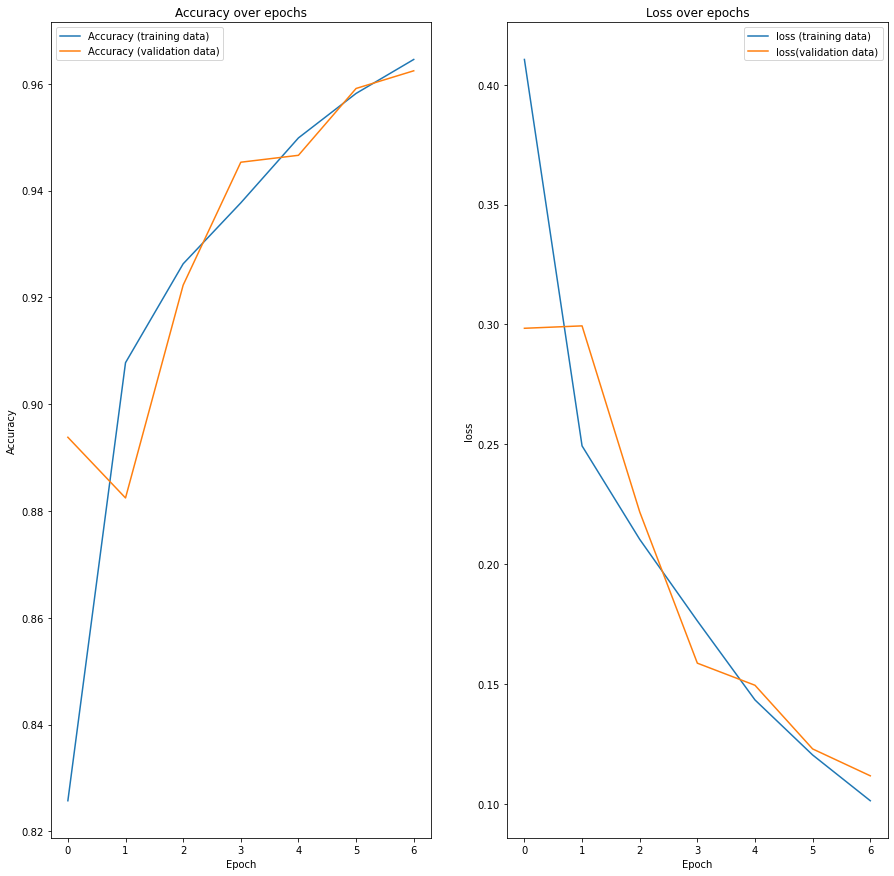

In [7]:
##Historique de l'apprentissage Modèle 4

#Score
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.plot(history3_1.history['accuracy'], label='Accuracy (training data)')
plt.plot(history3_1.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#Loss
plt.subplot(1,2,2)
plt.plot(history3_1.history['loss'], label='loss (training data)')
plt.plot(history3_1.history['val_loss'], label='loss(validation data)')
plt.title('Loss over epochs')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Évaluation du modèle 4 

In [8]:
# Chargez le modèle à partir du fichier
with open('/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/neuro_conv4.pkl', 'rb') as fichier:
    model3 = pickle.load(fichier)

In [9]:
with h5py.File(val_filepath, 'r') as file:
    mean_val = file['spectrogramme'][:].mean()
    std_val = file['spectrogramme'][:].std()


with h5py.File(test_filepath, 'r') as file:
    mean_train = file['spectrogramme'][:].mean()
    std_train = file['spectrogramme'][:].std()

#Charger les données test
with h5py.File(test_filepath, 'r') as file:
    spectres_test = (file['spectrogramme'][:] - mean_train)/std_train
    post_label = file['post_label'][:]
    ech_test = [stri.decode('utf-8') for stri in file['ech'][:]] 

#Charger les données val
with h5py.File(val_filepath, 'r') as file:
    spectres_val = (file['spectrogramme'][:] - mean_val)/std_val
    ech_val = [stri.decode('utf-8') for stri in file['ech'][:]]

2023-12-31 17:15:38.782008: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2631287148 exceeds 10% of free system memory.


218/218 [==============================] - 261s 1s/step
voici le seuil médian 0.38084444
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      4140
         1.0       0.96      0.96      0.96      2811

    accuracy                           0.96      6951
   macro avg       0.96      0.96      0.96      6951
weighted avg       0.96      0.96      0.96      6951



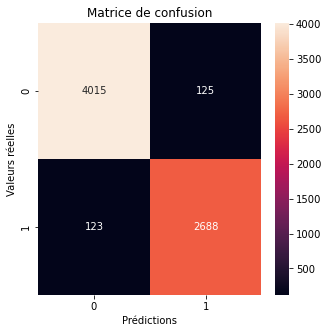

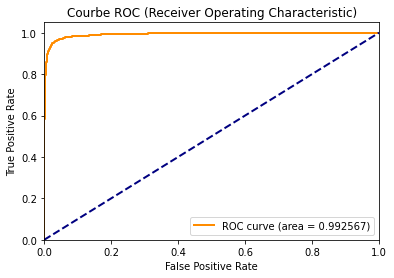

In [10]:
# Prédire les probabilités pour la classe positive
y_proba_pred_test = model3.predict(spectres_test)

# Calculer les scores TPR (True Positive Rate) et FPR (False Positive Rate)
fpr, tpr, thresholds = roc_curve(post_label, y_proba_pred_test)

#Trouver le bon indice pour le seuil de décision, au milieu de la courbe Roc
indice = int(np.floor(len(thresholds)/2))
print( "voici le seuil médian" ,thresholds[indice-1])

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

#Prédiction sur le seuil précédent
Y_pred = y_proba_pred_test > thresholds[indice-1]

#Rapport de classification  
matrix_conf = confusion_matrix(post_label,Y_pred)
print(classification_report(post_label,Y_pred))

##Matrice de confusion 
plt.figure(figsize=(5,5))
sns.heatmap(matrix_conf,annot=True,fmt='g')
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()


# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.6f})') # aire sous la courbe
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.show()

30/30 [==============================] - 37s 1s/step


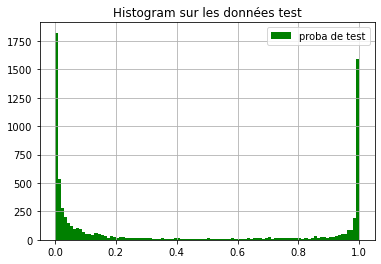

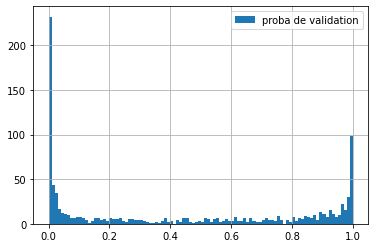

In [11]:
# Prédire les probabilités pour la classe positive
y_proba_pred_val = model3.predict(spectres_val)

plt.hist(y_proba_pred_test,100,color='g',density=False,label='proba de test')
plt.grid()
plt.legend()
plt.title("Histogram sur les données test")
plt.show()


plt.hist(y_proba_pred_val,100,density=False,label='proba de validation')
plt.grid()
plt.legend()
plt.show()

df_soumission12= pd.DataFrame(ech_val)
df_soumission12['pos_label'] = y_proba_pred_val
df_soumission12.index = df_soumission12[0]
df_soumission12.index.name = "id"
df_soumission12.drop(columns=0,axis=1,inplace=True)
df_soumission12.to_csv("/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/soumission12.csv")